In [1]:
from utils import *

In [2]:
plt.rcParams["figure.facecolor"] = "white"

In [3]:
pool = Pool(4)

In [4]:
g0 = 2.0
ka = 3.0
b  = 0.1
o0 = 1.0

In [5]:
R,S,H = (1/o0**2,1,0)

In [6]:
N=10000
warmup=30000
warmup_dt = 0.01
dt=0.01
samples=100
skip=10
runs=300
time = np.linspace(0,N*dt, N//skip)

In [8]:
print("warmup required: ",np.max(1/np.real(rootsPolyOmega(g0,ka,b,o0)))/warmup_dt)

print("memory required: ", (len([1]) * (N// skip) * runs * samples *8 ) * 8 / 1024**3)
print("relaxation time: ", np.max(1/np.real(rootsPolyOmega(g0,ka,b,o0))))
print("result time:     ", time[-1])

warmup required:  190.4259856862627
memory required:  1.7881393432617188
relaxation time:  1.904259856862627
result time:      100.0


In [9]:
sigma = get_cov(np.array([R]), np.array([S]), np.array([H]))

In [10]:
x0,y0,vx0,vy0 = np.random.multivariate_normal([0,0,0,0], sigma[...,0], samples).T
kwargs = dict(x0=x0,y0=y0,vx0=vx0,vy0=vy0,
    N=N, samples=samples,
    dt=dt, warmup=warmup,warmup_dt=warmup_dt, skip=skip,
    omega0=o0,gamma0=g0,b=b, theta=ka,kappa=ka)
result = simulate_2d_strong(pool,runs,**kwargs)

In [13]:
result = np.array(result); result.shape

(8, 30000, 1000)

### Start Analisys

In [14]:
cov_all = np.einsum("akj,bkj->jab", result[:4,:,:],result[:4,:,:],optimize=True)/(result.shape[1]-1)
# cov = cov[df[df.b].index]

In [15]:
cov=cov_all[:1000]

In [16]:
sp = 1
cov_R = cov[::sp,(0,1),(0,1)].transpose(0,1).reshape(-1,2)
cov_S = cov[::sp,(2,3),(2,3)].transpose(0,1).reshape(-1, 2)
cov_H = cov[::sp,(0,1,2,3),(3,2,1,0)].transpose(0,1).reshape(-1, 4)
cov_Z = cov[::sp,(0,0,1,1,2,2,3,3),(1,2,0,3,0,3,1,2)].transpose(0,1).reshape(-1, 8)

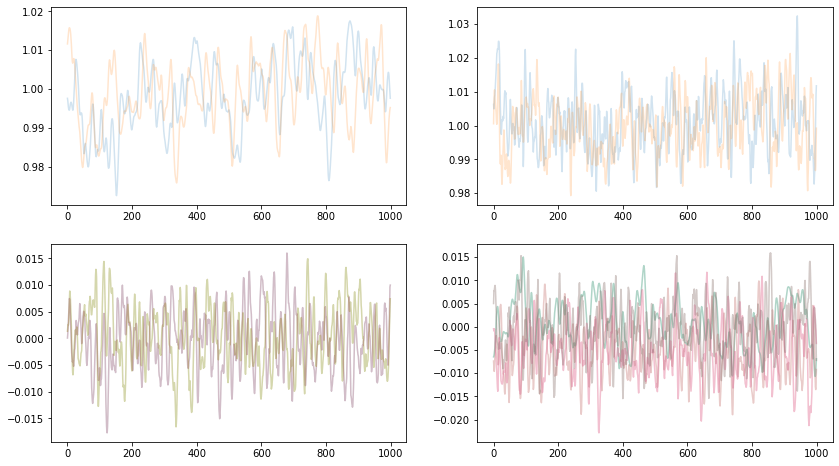

In [17]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(cov_R, alpha=0.2);
plt.subplot(2,2,2)
plt.plot(cov_S, alpha=0.2);
plt.subplot(2,2,3)
plt.plot(cov_H, alpha=0.2);
plt.subplot(2,2,4)
plt.plot(cov_Z, alpha=0.2);

In [18]:
stationari_treshold = 0

### Theory

In [19]:
1j*rootsPolyOmega(g0,ka,b,o0)

array([ 0.02781223+0.52513841j, -2.10618048+1.20228529j,
        1.97836825+1.2725763j ])

In [20]:
def Cxy_theory(t, gamma,kappa,b,omega0):
    omega1,omega2,omega3 = 1j*rootsPolyOmega(gamma,kappa,b,omega0)
    def Conjugate(x):
        return np.conj(x)
    
    return -np.imag((2 * 1j * np.e**(1j * t * omega1) * gamma * kappa**2)/((omega1 - omega2) * 
(omega1 - omega3) * (omega1 - 
    Conjugate(omega1)) * (omega1 - 
    Conjugate(omega2)) * (omega1 - Conjugate(omega3))) + (
 2 * 1j * np.e**(1j * t * omega2) * gamma * kappa**2)/((-omega1 + omega2) * 
(omega2 - omega3) * (omega2 - 
    Conjugate(omega1)) * (omega2 - 
    Conjugate(omega2)) * (omega2 - Conjugate(omega3))) + (
 2 * 1j * np.e**(1j * t * omega3) * gamma * kappa**2)/((-omega1 + omega3) * 
(-omega2 + omega3) * (omega3 - 
    Conjugate(omega1)) * (omega3 - 
    Conjugate(omega2)) * (omega3 - Conjugate(omega3))))

def Cvxvy_theory(t, gamma,kappa,b,omega0):
    omega1,omega2,omega3 = 1j*rootsPolyOmega(gamma,kappa,b,omega0)
    def Conjugate(x):
        return np.conj(x)
    
    return -np.imag((2 * 1j * omega1**2 * np.e**(1j * t * omega1) * gamma * kappa**2)/((omega1 - omega2) * 
(omega1 - omega3) * (omega1 - 
    Conjugate(omega1)) * (omega1 - 
    Conjugate(omega2)) * (omega1 - Conjugate(omega3))) + (
 2 * 1j * omega2**2 * np.e**(1j * t * omega2) * gamma * kappa**2)/((-omega1 + omega2) * 
(omega2 - omega3) * (omega2 - 
    Conjugate(omega1)) * (omega2 - 
    Conjugate(omega2)) * (omega2 - Conjugate(omega3))) + (
 2 * 1j * omega3**2 * np.e**(1j * t * omega3) * gamma * kappa**2)/((-omega1 + omega3) * 
(-omega2 + omega3) * (omega3 - 
    Conjugate(omega1)) * (omega3 - 
    Conjugate(omega2)) * (omega3 - Conjugate(omega3))))

def Cxvy_theory(t, gamma,kappa,b,omega0):
    omega1,omega2,omega3 = 1j*rootsPolyOmega(gamma,kappa,b,omega0)
    def Conjugate(x):
        return np.conj(x)
    
    return -np.imag((2 * omega1 * np.e**(1j * t * omega1) * gamma * kappa**2)/((omega1 - omega2) * 
(omega1 - omega3) * (omega1 - 
    Conjugate(omega1)) * (omega1 - 
    Conjugate(omega2)) * (omega1 - Conjugate(omega3))) + (
 2 * omega2 * np.e**(1j * t * omega2) * gamma * kappa**2)/((-omega1 + omega2) * 
(omega2 - omega3) * (omega2 - 
    Conjugate(omega1)) * (omega2 - 
    Conjugate(omega2)) * (omega2 - Conjugate(omega3))) + (
 2 * omega3 * np.e**(1j * t * omega3) * gamma * kappa**2)/((-omega1 + omega3) * 
(-omega2 + omega3) * (omega3 - 
    Conjugate(omega1)) * (omega3 - 
    Conjugate(omega2)) * (omega3 - Conjugate(omega3))))

### Autocorrelations

In [21]:
result.shape

(8, 30000, 1000)

In [22]:
x,y,vx,vy = result[:4]

In [23]:
dn = 1
ts = []
Cxvy, Cxvy_err = [], []
Cvxvy, Cvxvy_err = [], []
sz = 400
for n in tqdm(range(1,x.shape[1],dn)):
    ts.append(n*skip*dt)
    m,e = mean_with_err((x[:,n:][:,:sz]*vy[:,:-n][:,:sz]).flatten())
#     m,e = mean_with_err((x[:,n]*vy[:,0]).flatten())
    Cxvy.append(m)
    Cxvy_err.append(e)

    m,e = mean_with_err((vx[:,n:][:,:sz]*vy[:,:-n][:,:sz]).flatten())
#     m,e = mean_with_err((x[:,n]*vy[:,0]).flatten())
    Cvxvy.append(m)
    Cvxvy_err.append(e)


In [24]:
np.std(x)

0.9990154871410855

(0.0, 20.0)

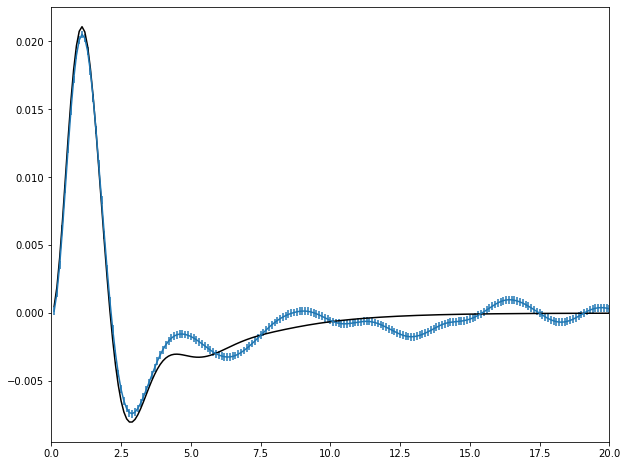

In [25]:
plt.figure(figsize=(10,8))
plt.errorbar(ts,Cxvy,yerr=Cxvy_err)
plt.plot(ts, [Cxvy_theory(s,g0,ka,b,o0) for s in ts], c="k")
plt.xlim(0,20)
# X(t)Vy(0)

(0.0, 20.0)

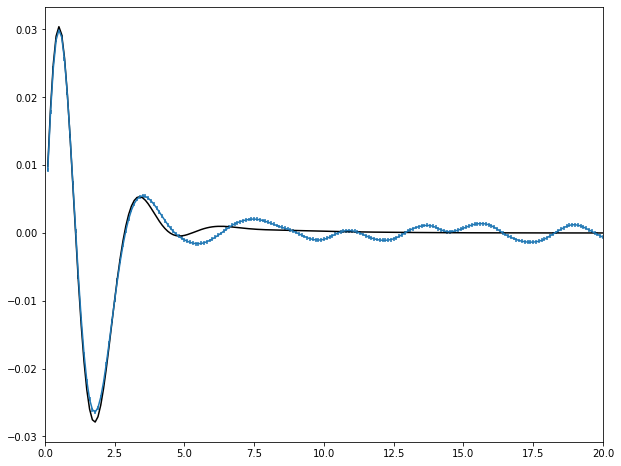

In [26]:
plt.figure(figsize=(10,8))
plt.errorbar(ts,Cvxvy,yerr=Cxvy_err)
plt.plot(ts, [Cvxvy_theory(s,g0,ka,b,o0) for s in ts], c="k")
plt.xlim(0,20)
# Vx(t)Vy(0)